<a href="https://colab.research.google.com/github/amnnsharma/GlidePro/blob/main/Pump_Off_Control_SRP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SRP WELL SECTION


In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
import tqdm
from itertools import product
from typing import Union
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose, STL


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [84]:
%cd /content/drive/My Drive/
df= pd.read_excel("SRP Well.xlsx", sheet_name='4')

/content/drive/My Drive


In [85]:
df.columns=['date', 'voltage1', 'voltage1', 'voltage1','power1','name', 'current1', 'current2', 'current3', 'power2', 'status']

In [86]:
df

,date,voltage1,voltage1,voltage1,power1,name,current1,current2,current3,power2,status
0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
745,2024-04-30 14:03:24.546,427.782104,428.782104,430.782104,18499840.0,GM197,6.979013,6.897690,7.200804,13718076.0,ON
746,2024-04-30 15:03:24.546,426.000000,427.000000,428.000000,18500042.0,GM197,0.000000,0.000000,0.000000,0.0,OFF
747,2024-04-30 16:03:24.546,432.028137,433.028137,435.000000,18500058.0,GM197,9.067492,8.902276,9.349333,18033646.0,ON
748,2024-04-30 17:03:24.546,435.000000,436.000000,438.000000,18502698.0,GM197,9.059199,8.859199,9.359199,18558374.0,ON


In [87]:
df = df.iloc[5:, :]
df.reset_index(drop=True, inplace=True)
#df['date'] = pd.to_datetime(df['date'])
df = df[df['status'] == 'ON']
df=df.drop(df.columns[[5, 10]], axis=1)
df = df.apply(pd.to_numeric, errors='coerce')
df = df.dropna()
df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d %H:%M:%S')
df

,date,voltage1,voltage1,voltage1,power1,current1,current2,current3,power2
0,2024-03-30 18:03:24,458.000000,459.000000,460.000000,16840636.0,6.530000,6.380000,6.900000,16874384.0
1,2024-03-30 19:03:24,458.000000,459.000000,460.000000,16840636.0,6.530000,6.380000,6.900000,16874384.0
2,2024-03-30 20:03:24,458.000000,459.000000,460.000000,16840636.0,6.530000,6.380000,6.900000,16874384.0
3,2024-03-30 21:03:24,458.000000,459.000000,460.000000,16840636.0,6.530000,6.380000,6.900000,16874384.0
4,2024-03-30 22:03:24,458.000000,459.000000,460.000000,16840636.0,6.530000,6.380000,6.900000,16874384.0
...,...,...,...,...,...,...,...,...,...
739,2024-04-30 13:03:24,429.871246,431.000000,432.000000,18497012.0,9.141068,9.028493,9.392356,18534080.0
740,2024-04-30 14:03:24,427.782104,428.782104,430.782104,18499840.0,6.979013,6.897690,7.200804,13718076.0
742,2024-04-30 16:03:24,432.028137,433.028137,435.000000,18500058.0,9.067492,8.902276,9.349333,18033646.0
743,2024-04-30 17:03:24,435.000000,436.000000,438.000000,18502698.0,9.059199,8.859199,9.359199,18558374.0


In [88]:
df.shape

(677, 9)

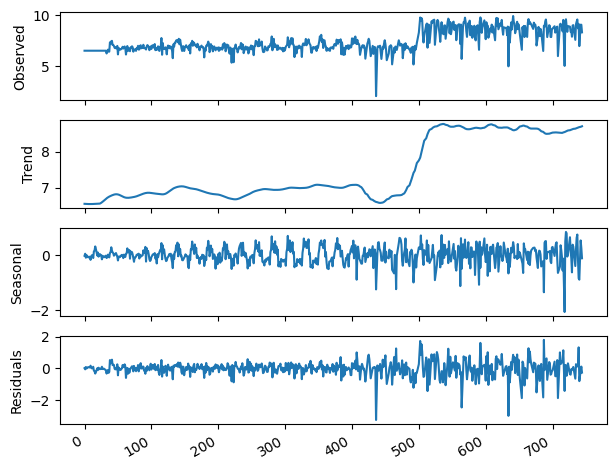

In [89]:
period=24

advanced_decomposition = STL(df.current1, period=period).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot( advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')


fig.autofmt_xdate()
plt.tight_layout()

In [90]:
trend=advanced_decomposition.trend.to_list()

In [91]:
len(trend)

677

In [92]:
#trend[421]

In [93]:
df['date'] = pd.to_datetime(df['date'])
df['date']

0     2024-03-30 18:03:24
1     2024-03-30 19:03:24
2     2024-03-30 20:03:24
3     2024-03-30 21:03:24
4     2024-03-30 22:03:24
              ...        
739   2024-04-30 13:03:24
740   2024-04-30 14:03:24
742   2024-04-30 16:03:24
743   2024-04-30 17:03:24
744   2024-04-30 18:03:24
Name: date, Length: 677, dtype: datetime64[ns]

ALERT:
Since 2024-04-20 08:03:24
#Load is increasing on the SRP system
#Unit balancing needed


[]

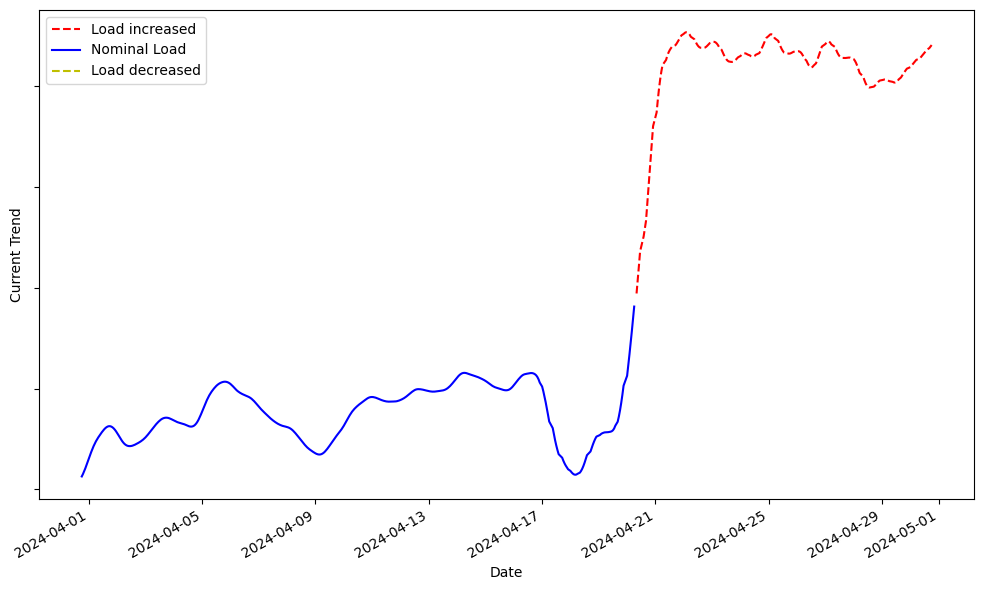

In [94]:
message_high=False
message_low=False
x_low=[]
y_low=[]
x_ok=[]
y_ok=[]
x_high=[]
y_high=[]
offset_factor=0.1
up_limit=1+offset_factor
low_limit=1-offset_factor
for i in range(period, len(advanced_decomposition.trend)):

  if (trend[i]> trend[i-period] and trend[i]>up_limit*trend[i-period]) or message_high==True:
    x_high.append(df['date'].to_list()[i])
    y_high.append(trend[i])
    if message_high==False:
      x_high.append(df['date'].to_list()[i])
      y_high.append(trend[i])
      print("ALERT:")
      print("Since "+str(df['date'].to_list()[i]))
      print("#Load is increasing on the SRP system")
      print("#Unit balancing needed")
      message_high=True
      message_low=False


  elif (trend[i]< trend[i-period] and trend[i]<low_limit*trend[i]) or message_low==True:
    x_low.append(df['date'].to_list()[i-period])
    y_low.append(trend[i])
    if message_low==False:
      x_low.append(df['date'].to_list()[i-period])
      y_low.append(trend[i])
      print("ALERT:")
      print("Since "+str(df['date'].to_list()[i]))
      print("#Load is decreasing on the SRP system")
      print("#Unit balancing needed")
      message_high=False
      message_low=True



  else:
    x_ok.append(df['date'].to_list()[i])
    y_ok.append(trend[i])
    message_high=False
    message_low=False


fig, ax=plt.subplots(figsize=(10, 6))

#x_combined= [x_low, x_ok, x_high]
#y_combined = [y_low, y_ok, y_high]
#labels=["Load decreased", "Nominal increased", "Load increased"]
#colors = ['yellow', 'blue', 'red']
#for x, y, color, label in zip(x_combined, y_combined, colors, labels):
#    ax.plot(x, y, color=color, label=label)

ax.plot(x_high, y_high, color='red', linestyle='--', label="Load increased", marker='')
ax.plot(x_ok, y_ok, color='blue', linestyle='-', label="Nominal Load", marker='')
ax.plot(x_low, y_low, color='y', linestyle='--', label="Load decreased", marker='')

ax.set_yticklabels([])
ax.set_xlabel("Date")
ax.set_ylabel("Current Trend")
fig.autofmt_xdate()
plt.tight_layout()
ax.legend()

plt.plot()

  #if load_increase==True:
    #print("ATTENTION!!!!")

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

In [ ]:
ADF_result = adfuller(np.diff(df.current1, n=1))

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -11.432532341653992
p-value: 6.464215856889524e-21


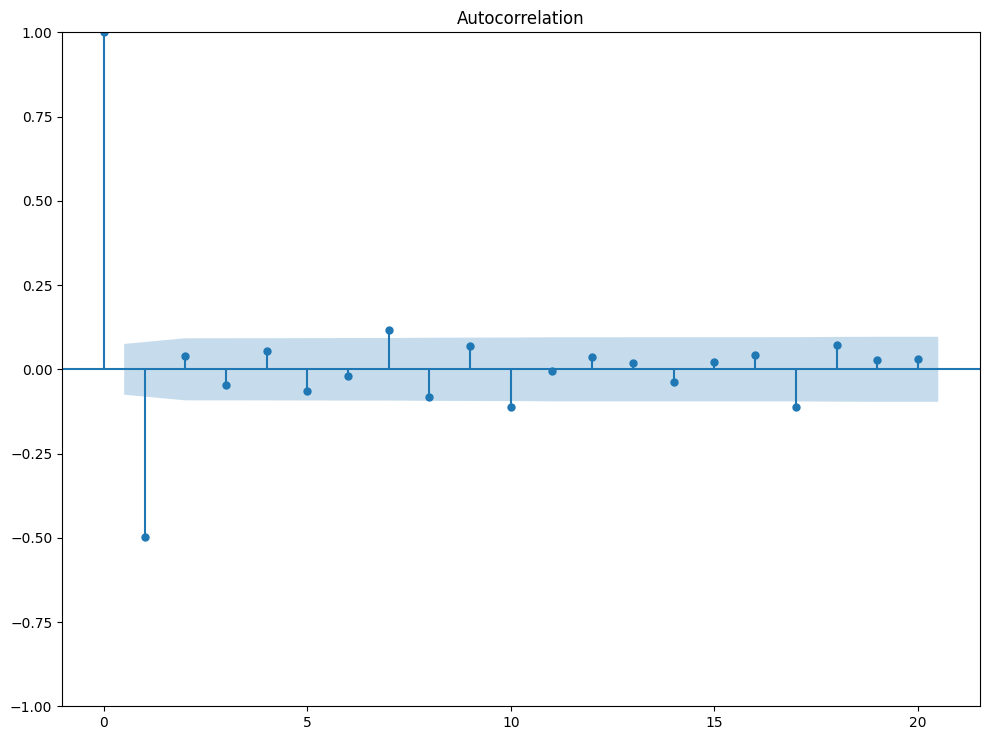

In [ ]:
plot_acf(np.diff(df.current1, n=1), lags=20)

plt.tight_layout()

In [ ]:
from prophet import Prophet
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

from sklearn.metrics import mean_absolute_error

from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [ ]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [ ]:
df=df[['date', 'current1']]
df.columns=['ds','y']
train = df[:-50]
test = df[-50:]

In [ ]:
train['ds']=pd.to_datetime(train['ds'])
train.shape

(627, 2)

In [ ]:
train.reset_index(drop=True, inplace=True)

In [ ]:
test['ds']=pd.to_datetime(test['ds'])
test.shape

(50, 2)

In [ ]:
test.reset_index(drop=True, inplace=True)

In [ ]:
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=50, freq='H')
print(future.shape)
forecast = m.predict(future)
print(forecast.shape)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq1hu57gn/x49yir1i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq1hu57gn/fvc9_kve.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23786', 'data', 'file=/tmp/tmpq1hu57gn/x49yir1i.json', 'init=/tmp/tmpq1hu57gn/fvc9_kve.json', 'output', 'file=/tmp/tmpq1hu57gn/prophet_modelnv1vbr7g/prophet_model-20240430201831.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:18:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:18:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


(677, 1)
(677, 19)


,ds,yhat,yhat_lower,yhat_upper
0,2024-03-30 18:03:24.546,6.831681,6.143093,7.551811
1,2024-03-30 19:03:24.546,6.667990,5.978206,7.334606
2,2024-03-30 20:03:24.546,6.459157,5.712472,7.095360
3,2024-03-30 21:03:24.546,6.306641,5.609280,7.015408
4,2024-03-30 22:03:24.546,6.264244,5.567585,6.982182
...,...,...,...,...
672,2024-04-30 00:03:24.546,9.230897,8.540276,9.949667
673,2024-04-30 01:03:24.546,9.332851,8.602969,10.075538
674,2024-04-30 02:03:24.546,9.395753,8.654523,10.039939
675,2024-04-30 03:03:24.546,9.393942,8.627946,10.036658


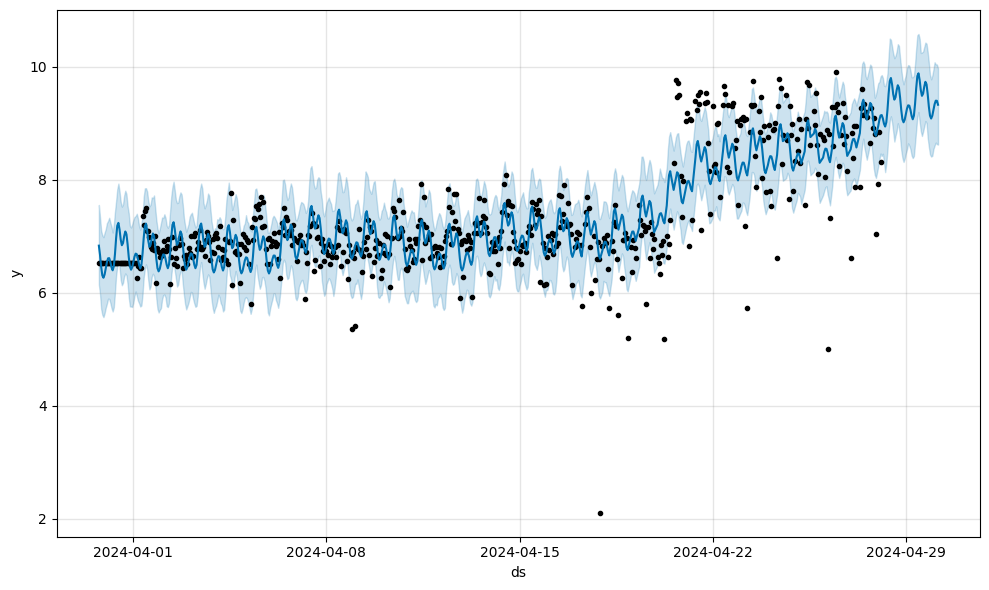

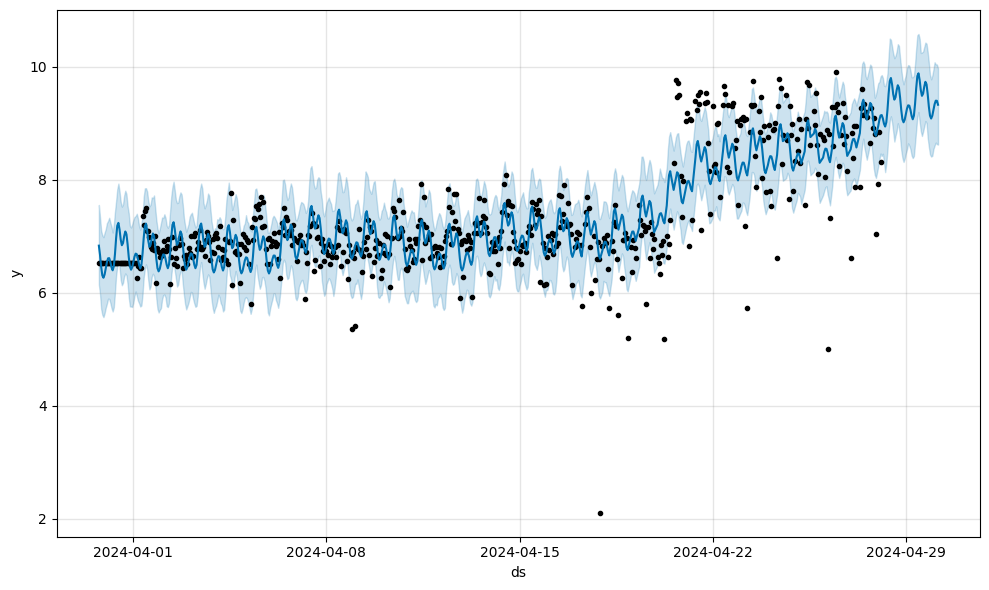

In [ ]:
m.plot(forecast)

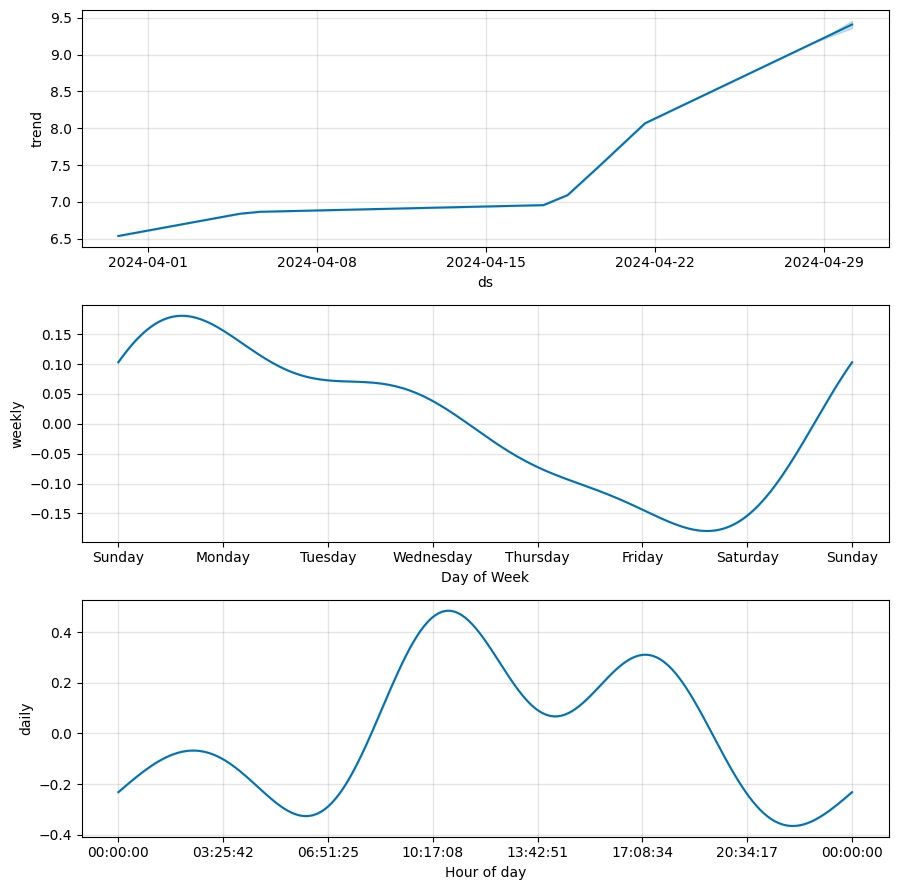

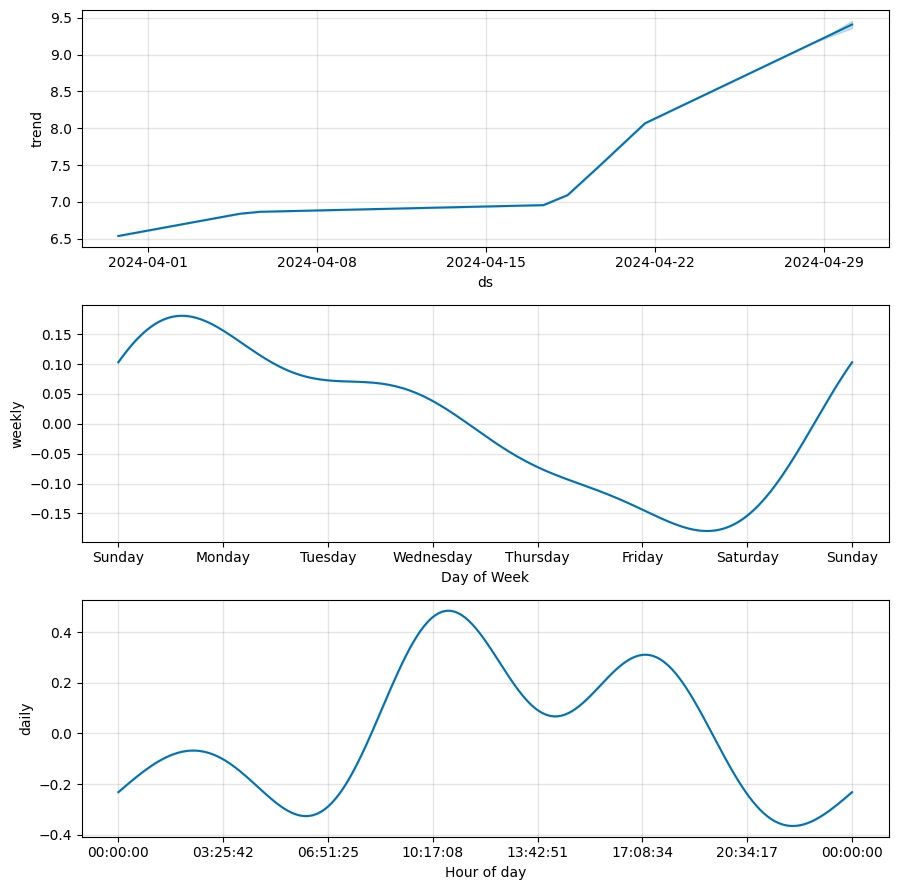

In [ ]:
m.plot_components(forecast)

In [ ]:
forecast.reset_index(drop=True, inplace=True)

In [ ]:
forecast.shape

(677, 19)

In [ ]:
test

,ds,y
0,2024-04-28 03:03:24.546,7.949500
1,2024-04-28 04:03:24.546,8.659343
2,2024-04-28 05:03:24.546,8.422954
3,2024-04-28 08:03:24.546,6.503767
4,2024-04-28 09:03:24.546,8.960000
5,2024-04-28 10:03:24.546,8.847548
6,2024-04-28 11:03:24.546,9.364697
7,2024-04-28 12:03:24.546,9.573962
8,2024-04-28 13:03:24.546,8.976000
9,2024-04-28 14:03:24.546,7.859227


In [ ]:
forecast=forecast[['yhat', 'yhat_lower', 'yhat_upper']][-50:]

In [ ]:
forecast.reset_index(drop=True, inplace=True)

In [ ]:
test[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]
test.head()

,ds,y,yhat,yhat_lower,yhat_upper
0,2024-04-28 03:03:24.546,7.949500,9.141778,8.475036,9.876004
1,2024-04-28 04:03:24.546,8.659343,9.080681,8.382264,9.763608
2,2024-04-28 05:03:24.546,8.422954,8.987581,8.308307,9.692652
3,2024-04-28 08:03:24.546,6.503767,8.938792,8.254071,9.657798
4,2024-04-28 09:03:24.546,8.960000,9.012950,8.303858,9.734073


In [ ]:
test['baseline'] = train['y'][-50:].values
test.head()

,ds,y,yhat,yhat_lower,yhat_upper,baseline
0,2024-04-28 03:03:24.546,7.949500,9.141778,8.475036,9.876004,9.680220
1,2024-04-28 04:03:24.546,8.659343,9.080681,8.382264,9.763608,8.617383
2,2024-04-28 05:03:24.546,8.422954,8.987581,8.308307,9.692652,9.204837
3,2024-04-28 08:03:24.546,6.503767,8.938792,8.254071,9.657798,8.964043
4,2024-04-28 09:03:24.546,8.960000,9.012950,8.303858,9.734073,9.529994


In [ ]:
from sklearn.metrics import mean_absolute_error

prophet_mae = mean_absolute_error(test['y'], test['yhat'])
baseline_mae = mean_absolute_error(test['y'], test['baseline'])

print(prophet_mae)
print(baseline_mae)

0.8603254227659075
0.7566275119781501


In [ ]:
test.iloc[49]

ds            2024-04-30 18:03:24.546000
y                                   8.32
yhat                            9.324429
yhat_lower                      8.555882
yhat_upper                     10.034584
baseline                        8.306691
Name: 49, dtype: object

In [ ]:
test.index = range(int(train.shape[0]), 50 + int(train.shape[0]))

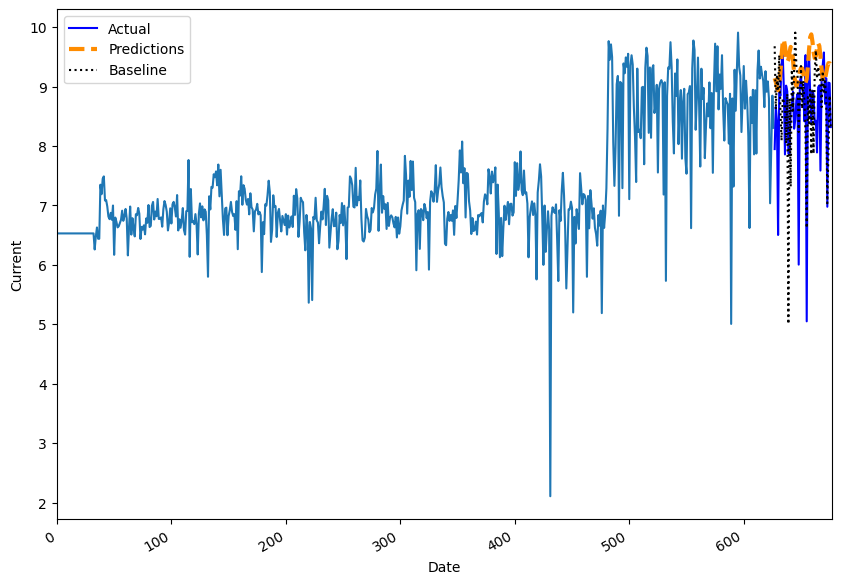

In [ ]:
fig, ax = plt.subplots()

ax.plot(train['y'])
ax.plot(test['y'], 'b-', label='Actual')
ax.plot(test['yhat'], color='darkorange', ls='--', lw=3, label='Predictions')
ax.plot(test['baseline'], 'k:', label='Baseline')

ax.set_xlabel('Date')
ax.set_ylabel('Current')

ax.axvspan(3285, 3649, color='#808080', alpha=0.1)

ax.legend(loc='best')

#plt.xticks(
#    [3224, 3254, 3285, 3316, 3344, 3375, 3405, 3436, 3466, 3497, 3528, 3558, 3589, 3619],
#    ['Nov', 'Dec', 'Jan 1990', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
#plt.fill_between(x=test.index, y1=test['yhat_lower'], y2=test['yhat_upper'], color='lightblue')
plt.xlim(0, test.shape[0]+train.shape[0])

fig.autofmt_xdate()
#plt.tight_layout()

#plt.savefig('figures/CH19_F03_peixeiro.png', dpi=300)

KeyError: 'ds'

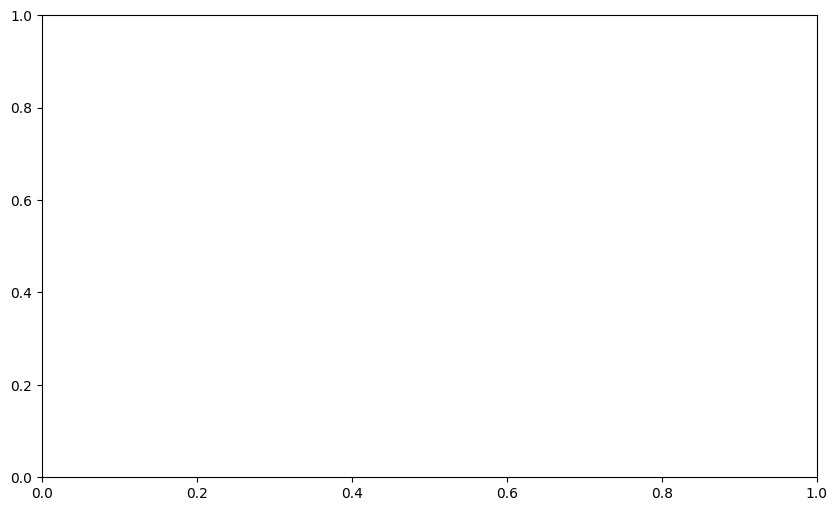

In [ ]:
#m.plot(forecast)